# 练习7：kmeans和PCA

## Kmeas

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib.cm as cm

###  查看数据

In [6]:
data = sio.loadmat('./data/ex7data2.mat')
X = data['X']
X.shape

(300, 2)

Text(0.5, 1.0, 'Plot of X Points')

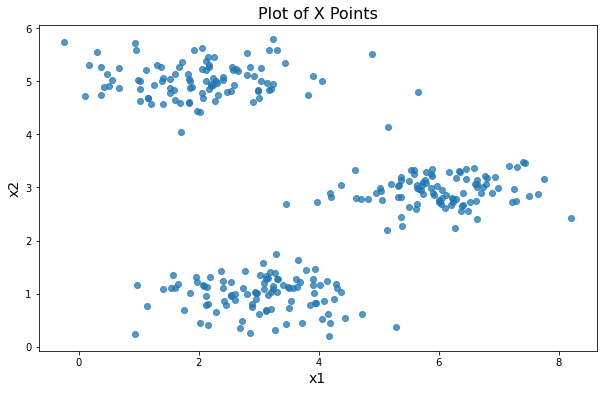

In [14]:
plt.figure(figsize=(10,6))
plt.plot(X[:,0],X[:,1],'o', alpha=0.75, label='Data Points: Cluster ')
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.title('Plot of X Points',fontsize=16)

### 寻找最近簇中心

In [10]:
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    for i in range(m):
        min_dist = 1000000
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    
    return idx

In [13]:
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
idx = find_closest_centroids(X, initial_centroids)
idx[:3]

array([0., 2., 1.])

### 计算簇中心平均值
也就是重新更新簇坐标

In [16]:
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    
    for i in range(k):
        indices = np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centroids

In [17]:
compute_centroids(X, idx, 3)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

### kmeans

In [25]:
def kmeans(X, initial_centroids, k, iters):
    idx = np.zeros(X.shape[0])
    centroids_history = []
    centroids = initial_centroids
    centroids_history.append(centroids)
    for i in range(iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
        centroids_history.append(centroids)
        
    return idx,centroids, centroids_history

In [27]:
k=3
iters=100
idx,final_centroids, centroids_history = kmeans(X, initial_centroids, k, iters)
final_centroids

array([[1.95399466, 5.02557006],
       [3.04367119, 1.01541041],
       [6.03366736, 3.00052511]])

绘图展示下

In [69]:
def plot_kmeans(X, k, initial_centroids, iters):
    color_array = ['r','darkorange','b','y','g','salmon','olivedrab']
    idx,final_centroids, centroids_history = kmeans(X, initial_centroids, k, iters)
    
    tracex, tracey = [], []
    for mycentroid in centroids_history:
        tracex.append(mycentroid[:,0])
        tracey.append(mycentroid[:,1])
    
    tracex = np.array(tracex)
    tracey = np.array(tracey)
    
    plt.figure(figsize=(10,6))
    for i in range(k):
        cluster = X[np.where(idx == i)[0],:]
        plt.plot(cluster[:,0],cluster[:,1],'o',color=color_array[i], label='Data Points: Cluster %d'%i)
        plt.plot(tracex[:,i], tracey[:,i], 'x--',color=color_array[i+3] ,markersize=8)      

    plt.xlabel('x1',fontsize=14)
    plt.ylabel('x2',fontsize=14)
    plt.title('Plot of X Points',fontsize=16)
    plt.legend()

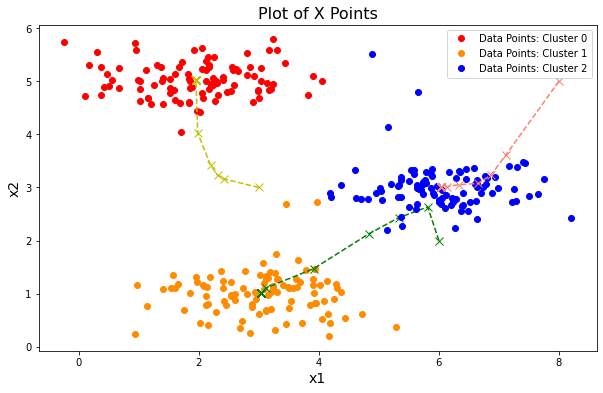

In [70]:
plot_kmeans(X, k, initial_centroids, 100)

### 随机初始化

选择随机样本并将其用作初始聚类中心

In [65]:
def random_init_centroids(X, k):
    idx = np.random.randint(0, X.shape[0], k)
    return np.array([X[i] for i in idx])  

In [66]:
random_init_centroids(X, 3)

array([[5.64034678, 2.69385282],
       [3.95549912, 0.83269299],
       [2.04974595, 5.6241395 ]])

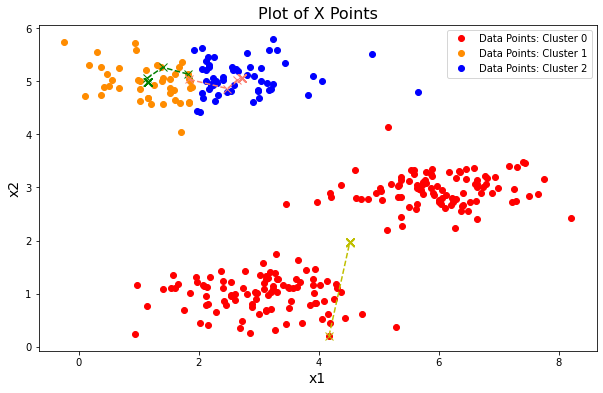

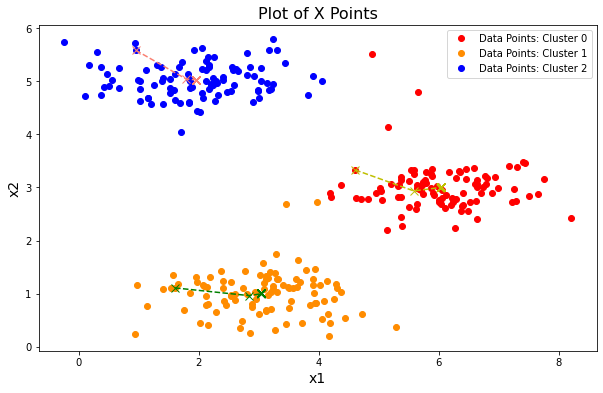

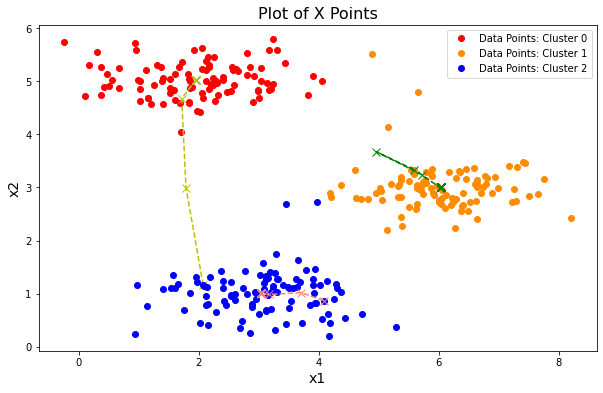

In [71]:
k=3
for i in range(3):
    initial_centroids = random_init_centroids(X, 3)
    plot_kmeans(X, k, initial_centroids, 100)

## kmeans 图像压缩应用

A shape is  (128, 128, 3)


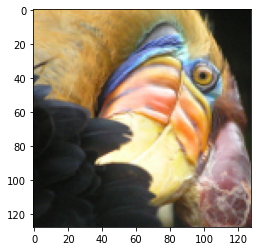

In [79]:
from scipy import misc
import matplotlib.image as mpimg

A = mpimg.imread('./data/bird_small.png')
print ("A shape is ",A.shape)
img = plt.imshow(A)

In [81]:
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2])) # 128*128 
X.shape

(16384, 3)

使用kmeans进行图像压缩

In [83]:
k=16
iters = 10
initial_centroids = random_init_centroids(X, k)
idx,final_centroids, centroids_history = kmeans(X, initial_centroids, k, iters)

In [107]:
X_recovered = np.array([final_centroids[int(idx[i]),:] for i in range(X.shape[0])])
X_recovered.shape

(16384, 3)

In [108]:
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

(128, 128, 3)

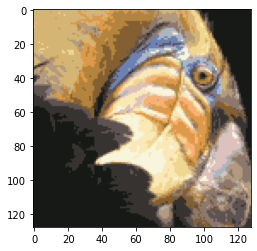

In [109]:
img = plt.imshow(X_recovered)

### 使用sklearn

In [112]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=16, n_init=100)
model.fit(X)
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(X)
print(C.shape)

(16, 3)
(16384,)


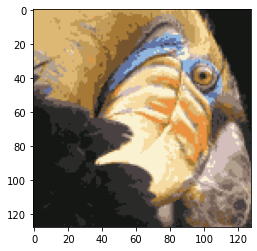

In [115]:
compressed_pic = centroids[C].reshape((128,128,3))
img = plt.imshow(compressed_pic)

## PCA 主成分分析

### 查看数据

In [124]:
data2 = sio.loadmat('./data/ex7data1.mat')
X = data2['X']

Text(0.5, 1.0, 'Plot of X Points')

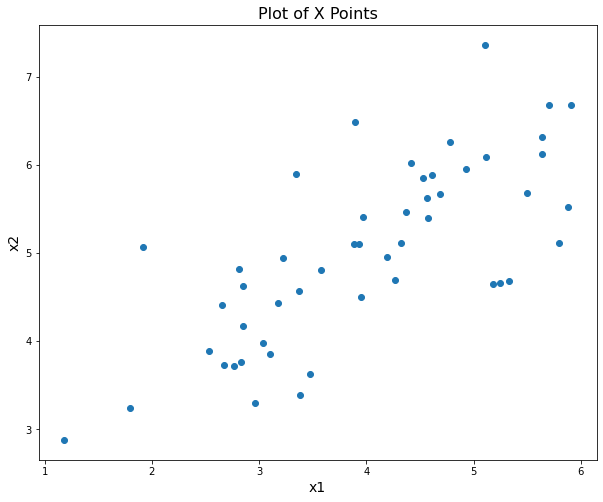

In [125]:
plt.figure(figsize=(10,8))
plt.plot(X[:,0],X[:,1],'o')
plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.title('Plot of X Points',fontsize=16)

### PCA实现

In [142]:
from scipy import linalg 

def PCA(X):
    # 标准化
    X_norm = (X - np.mean(X,axis=0))/np.std(X,axis=0)
    
    # 计算协方差矩阵
    X_norm = np.matrix(X_norm)
    covMatrix = (X_norm.T * X_norm) / X_norm.shape[0]
    
    # 奇异值分解
    U, S, V = np.linalg.svd(covMatrix)
    return U, S, V

In [144]:
U, S, V = PCA(X)